---
title: Prediction intervals
toc: true
toc_sticky: true
---

I meant to post this some time ago, but I have been busy. But with the baseball example I am using, it is only fitting that I post this now, just after this year's strange timing of MLB's Opening Day. (My team had a [nice win!](https://www.sandiegouniontribune.com/sports/padres/story/2020-07-24/padres-diamondbacks-chris-paddack-madison-bumgarner-eric-hosmer-opening-day))

In my last post, I applied Bayes' theorem towards revealing a hypothetical player's probability distribution for their hit rate after observing their performance for a given time. Essentially, we found the player's posterior distribution. However, because the prior we were given was a [Bernoulli distribution](https://brilliant.org/wiki/bernoulli-distribution/), so was the resulting posterior. This is not realistic. We would instead expect the distribution to *appear* Gaussian. (I emphasize "appear" for reasons you will see down below.) A Bernoulli distribution also does not really allow us to apply the concept of a [credible interval](https://en.wikipedia.org/wiki/Credible_interval).

Let's re-examine the problem with a different, more realistic prior!

By the way, David Robinson already wrote a [superb post](http://varianceexplained.org/r/credible_intervals_baseball/) on credible intervals, which also happened to use baseball statistics. I wanted to build on my previous example here, but I used his article for reference. I also found [this useful reference from Carnegie Mellon Statistics](http://www.stat.cmu.edu/~brian/463-663/week09/Chapter%2003.pdf) and reviewed a Bayesian statistics course I completed from [Coursera add link](xxx).

In [2]:
# Load packages for coding examples
import pandas as pd
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import beta
from scipy.stats import binom
from scipy.stats import norm
sns.set_context('talk')   # visual theme

I won't restate the whole problem, but you can find it in the [previous post](https://benslack19.github.io/data%20science/statistics/b-bayes-ball/) if you need a reminder.

What if we weren't asking for a single probability if Aguila was in the 10% hit rate group versus the 25% hit group? What if we asked where Aguila's batting average (hitting rate) would be across a *range* of talent levels? Let's take these steps in a couple of iterations. First, let's take the original Bernoulli distribution example and show how the prior distribution gets updated with data to produce the posterior distribution. I show this differently than I did in the last post.

# Using a more realistic prior: the beta distribution

In [154]:
# Generate different values of alpha (a) and beta (b)
total_ab_list = [25, 50, 75, 100, 125, 150, 200]
for total_ab in total_ab_list:
    # Get credible interval
    a = mu*total_ab
    b = total_ab-a
    print(beta.ppf([0.01, 0.99], a, b), total_ab, a, b)
    # print(beta.ppf([0.025, 0.975], a, b), total_ab, a, b)
    # print(beta.cdf([0.025, 0.975], a, b), total_ab, a, b)

[0.04336178 0.38055279] 25 4.375 20.625
[0.07179586 0.31583077] 50 8.75 41.25
[0.08718828 0.28803618] 75 13.125 61.875
[0.09716448 0.2718051 ] 100 17.5 82.5
[0.1043086  0.26089134] 125 21.875 103.125
[0.10975405 0.25292594] 150 26.25 123.75
[0.11763979 0.24188264] 200 35.0 165.0


We can see by looking at different values that an $\alpha$ and $\beta$ of 17.5 and 82.5 provide lower and upper bounds close to our desired values of 0.10 and 0.25. Great! We now have the parameters for our prior. I will call this $\alpha_{0}$ and $\beta_{0}$ going forward (or a0 and b0 in code). Let's plot this on its own.

a0, b0 values:  17.5 82.5


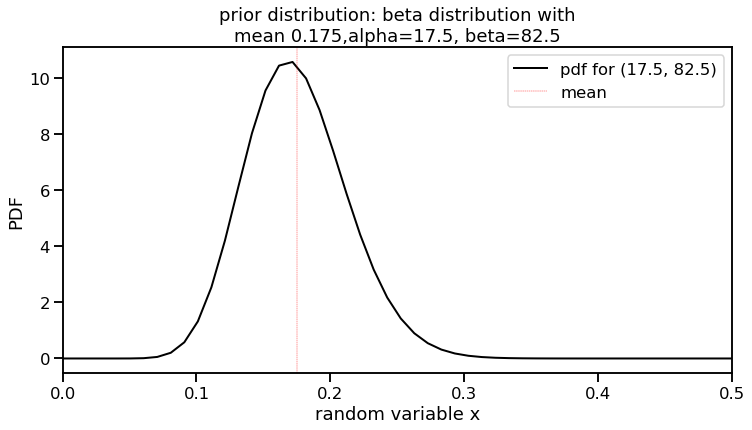

In [146]:
# Use a0 and b0 for our prior
total_ab = 100
a0 = mu*total_ab
b0 = total_ab-a0
print("a0, b0 values: ", a0, b0)


f, ax1 = plt.subplots(figsize=(12,6))

x = np.linspace(beta.ppf(0.00, a0, b0),
                beta.ppf(1.00, a0, b0), 100)
this_label = 'pdf for (' + str(a0) + ', ' + str(b0) + ')'

ax1.plot(x, beta.pdf(x, a0, b0), color='black',
         lw=2, label=this_label)
    
ax1.axvline(mu, lw=0.4, color='red', linestyle='dashed', label='mean')
ax1.set_title('prior distribution: beta distribution with\nmean 0.175,alpha=17.5, beta=82.5')
ax1.set_xlim([0, 0.5])
ax1.set_xlabel('random variable x')
ax1.set_ylabel('PDF')
ax1.legend();

In [157]:
a

18

In [160]:
np.math.factorial(4)

24

In [162]:
norm_constant = np.math.factorial(a+b-1) / (np.math.factorial(a-1)*np.math.factorial(b-1))
norm_constant

4.52608179452106e+20

In [163]:
(0.18*10) / norm_constant

3.976949780666684e-21

# Doing the math

Now let's add in the data from the original problem but make it more interesting. The original problem had Aguila getting 18 hits in 100 at-bats, which would essentially be the mean that we found above. Let's say instead that he goes on a small streak and gets 20 hits in only 50 at-bats, for a .400 batting average.

The Robinson post describes a super easy way to get the posterior distribution. But I wanted to understand the math so let's dive in.

Let's start simple and start with Bayes again.

$\text{P}(A|B) = \frac{\text{P}(B|A)\text{P}(A)}{\text{P}(B)}$

Now let's translate these terms into words and the context of our problem like we did in the previous post.

One change we have to consider is that the previous post was applying Bayes' Theorem towards a *point probability*. That is, we calculated a single, numerical value when we asked what probability would Aguila be in the T10 group. The prior was also a numerical value ("40% of all hitters were in the T10 group").

What we are really doing here is applying Bayes' Theorem towards a *probability distribution*. Therefore, we Bayes would be in a similar form as what we have above, but amended as:

$f(x|\text{data}) = \frac{f(\text{data}|x)f(x)}{f(\text{data})}$

Let's work through these terms as we did in the previous post.

$f(x|\text{data}) $ = This is the posterior probability distribution. We update the prior after seeing data. The left side of the equation is what we are trying to find and we'll come back to this.

The entire right side of the equation is information that we are given but is a little bit less intuitive to see.

$f(\text{data}|x)$ =  This is the sampling density for the data. **come back to this.**
<br>
$f(x)$ = This is our prior distribution, what we had determined above.
<br>
$f(\text{data})$ = **Come back to this.** This acts as a normalizing constant. $f(\text{data}) = \int f(\text{data}|x)f(x)dx$

**Remember, we are starting with a prior *distribution* parameterized by our random variable x. The resulting posterior will also be distribution that also is parameterized by x.**

We do not have to worry too much about the normalizing term as we'll see. 

Let's work through the terms individually.

The term $f(\text{data}|x)$ is our likelihood function or the sampling density for the data. You can see that the data is shown "given x" or given a random variable. Hence what we know is that the data shows a binomial distribution where n = 100.

$"n choose k" x^k (1-x)^{n-k}$




$\text{P}(\text{T10} | \text{18H}) = \frac{\text{P}(\text{18H} | \text{T10})\text{P}(\text{T10})}{\text{P}(\text{18H})}$

In [133]:
beta.pdf(0.18, a0, b0)

10.132582493050725

In [139]:
beta.pdf((beta.pdf(0.18, a0, b0)*x), a0, b0) / 0.18

array([0.00000000e+00, 8.07745099e+00, 3.88467568e+01, 4.15751709e-01,
       1.05582750e-04, 7.70228957e-10, 7.35511413e-17, 1.15625645e-26,
       1.48240606e-41, 3.68229493e-70, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [128]:
x

array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.25252525, 0.26262626, 0.27272727, 0.28282828, 0.29292929,
       0.3030303 , 0.31313131, 0.32323232, 0.33333333, 0.34343434,
       0.35353535, 0.36363636, 0.37373737, 0.38383838, 0.39393939,
       0.4040404 , 0.41414141, 0.42424242, 0.43434343, 0.44444444,
       0.45454545, 0.46464646, 0.47474747, 0.48484848, 0.49494949,
       0.50505051, 0.51515152, 0.52525253, 0.53535354, 0.54545455,
       0.55555556, 0.56565657, 0.57575758, 0.58585859, 0.5959596 ,
       0.60606061, 0.61616162, 0.62626263, 0.63636364, 0.64646465,
       0.65656566, 0.66666667, 0.67676768, 0.68686869, 0.6969697 ,
       0.70707071, 0.71717172, 0.72727273, 0.73737374, 0.74747

In [44]:
a_post = a + 18 
b_post = b + (100-18)
print("posterior a, b values: ", a_post, b_post)

posterior a, b values:  193 907


Why does the y-axis go above 1? It's a density. You can u

In [45]:
beta.cdf([0.125, 0.150, 0.175, 0.200, 0.225], a, b)

array([2.97946338e-06, 1.58518348e-02, 5.07194956e-01, 9.78651290e-01,
       9.99954847e-01])

In [46]:
# Get credible interval
beta.ppf([0.025, 0.975], a_post, b_post)

array([0.15693997, 0.19464029])

In [32]:
#beta.pdf(x_post, a_post, b_post)

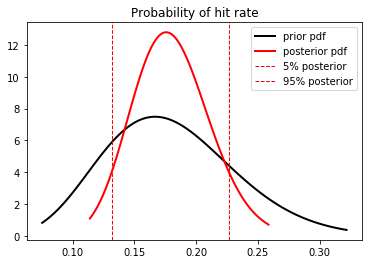

In [33]:
f, ax1 = plt.subplots()

ax1.plot(x, beta.pdf(x, a, b),
         'k-', lw=2, alpha=1, label='prior pdf')

x_post = np.linspace(beta.ppf(0.01, a_post, b_post),
                beta.ppf(0.99, a_post, b_post), 100)
ax1.plot(x_post, beta.pdf(x_post, a_post, b_post),
         'r-', lw=2, alpha=1, label='posterior pdf')
ax1.axvline(0.13198161, ymax=1, color='red', linestyle='dashed', lw=1, label='5% posterior')
ax1.axvline(0.22650857, ymax=1, color='red', linestyle='dashed', lw=1, label='95% posterior')

ax1.legend()
ax1.set_title('Probability of hit rate');

In [34]:
beta.pdf(x_post, a_post, b_post)

array([ 1.1003772 ,  1.25352291,  1.42155113,  1.60500699,  1.80434111,
        2.01989636,  2.25189531,  2.5004287 ,  2.76544517,  3.04674248,
        3.34396044,  3.65657579,  3.98389909,  4.32507386,  4.67907797,
        5.04472735,  5.42068205,  5.80545453,  6.1974202 ,  6.59483004,
        6.99582502,  7.3984524 ,  7.80068336,  8.20043195,  8.59557495,
        8.98397238,  9.36348843,  9.7320124 , 10.08747939, 10.42789046,
       10.75133204, 11.05599417, 11.34018745, 11.60235849, 11.84110365,
       12.05518085, 12.24351943, 12.40522799, 12.5396    , 12.64611733,
       12.72445168, 12.77446385, 12.79620107, 12.78989239, 12.75594232,
       12.69492279, 12.6075637 , 12.4947421 , 12.35747037, 12.19688336,
       12.01422487, 11.81083365, 11.58812895, 11.34759607, 11.09077176,
       10.81923003, 10.5345681 , 10.23839299,  9.9323087 ,  9.61790402,
        9.29674131,  8.97034604,  8.64019735,  8.30771964,  7.97427506,
        7.64115719,  7.30958562,  6.98070165,  6.65556492,  6.33

## Testing end result

In [155]:
a, b = 18, 82

a_post = 18+20
b_post = 82+30

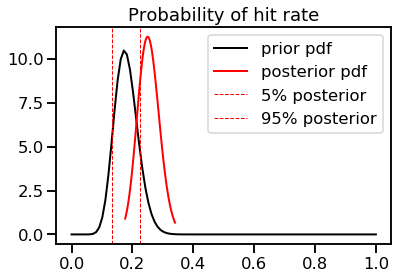

In [156]:
f, ax1 = plt.subplots()

ax1.plot(x, beta.pdf(x, a, b),
         'k-', lw=2, alpha=1, label='prior pdf')

x_post = np.linspace(beta.ppf(0.01, a_post, b_post),
                beta.ppf(0.99, a_post, b_post), 100)
ax1.plot(x_post, beta.pdf(x_post, a_post, b_post),
         'r-', lw=2, alpha=1, label='posterior pdf')
ax1.axvline(0.13198161, ymax=1, color='red', linestyle='dashed', lw=1, label='5% posterior')
ax1.axvline(0.22650857, ymax=1, color='red', linestyle='dashed', lw=1, label='95% posterior')

ax1.legend()
ax1.set_title('Probability of hit rate');

## Putting it all together

Let's return to the parameters of the Bayes' theorem equation and start bringing the pieces together.

${\text{P}(\text{18H})}$ = $\text{P}(\text{18H} | \text{T10})$ + $\text{P}(\text{18H} | \text{T25})$

We can apply the probability mass function starting first with the T10 group. (Note that we can ignore calculation of the binomial coefficient since this will cancel out in the final equation. I'll use the term $\propto$ to represent "in proportion to." in the equations below.)

$\text{P}(\text{18H} | \text{T10}) \propto (0.1^{18} \times 0.9^{82}) $

$\text{P}(\text{18H} | \text{T25}) \propto (0.25^{18} \times 0.75^{82}) $

We now have everything we need to plug into our equation.


$\text{P}(\text{T10} | \text{18H}) = \frac{\text{P}(\text{18H} | \text{T10})\text{P}(\text{T10})}{\text{P}(\text{18H})}$

$\text{P}(\text{T10} | \text{18H}) = \frac{(0.1^{18} \times 0.9^{82}) \times 0.6}{(0.1^{18} \times 0.9^{82}) \times 0.6 + (0.25^{18} \times 0.75^{82}) \times 0.4} $


After all that math, we have (drumroll) $\text{P}(\text{T10} | \text{18H}) = 0.243$.

Therefore, there is 24.3% probability that Aguila has a true talent level of a 10% hit rate.


The baseball example is also the diachronic interpretation** of Bayes' theorem, which is a fancy way of saying that the hypothesis can be updated with time (in this case, after 100 plate appearances).